In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from matplotlib import pyplot as plt
import seaborn as sns
import math
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
pip install openpyxl

Note: you may need to restart the kernel to use updated packages.


In [3]:
#Считаем данные в pandas DataFrame
data = pd.read_excel('data.xlsx')

Взглянем на данные.

In [4]:
data[:12]

,FIO,Месяц,Профессия,Разряд,Оборудование,Вредность (балл.),Объем производства,Доход
0,Абрамов Е. Д.,2009-01-01,Уборщик,3,Пилигримовые станы,18,580,16638.000000
1,Абрамов Е. Д.,2009-02-01,Уборщик,3,Пилигримовые станы,18,790,16638.000000
2,Абрамов Е. Д.,2009-03-01,Уборщик,3,Пилигримовые станы,18,820,16638.000000
3,Абрамов Е. Д.,2009-04-01,Уборщик,3,Пилигримовые станы,18,1200,19396.411765
4,Абрамов Е. Д.,2009-05-01,Уборщик,3,Пилигримовые станы,18,1250,19790.470588
5,Абрамов Е. Д.,2009-06-01,Уборщик,3,Пилигримовые станы,18,950,17426.117647
6,Абрамов Е. Д.,2009-07-01,Уборщик,3,Пилигримовые станы,18,1400,20972.647059
7,Абрамов Е. Д.,2009-08-01,Уборщик,3,Пилигримовые станы,18,1180,19238.788235
8,Абрамов Е. Д.,2009-09-01,Уборщик,3,Пилигримовые станы,18,1080,18450.670588
9,Абрамов Е. Д.,2009-10-01,Уборщик,3,Пилигримовые станы,18,780,16638.000000


In [5]:
data['Профессия'].value_counts()/12

Вальцовщик                              51.0
Нагревальщик металла                    42.0
Подручный вальцовщика                   30.0
Оператор поста управления               27.0
Уборщик                                 21.0
Контролер качества готовой продукции     9.0
Посадчик металла                         8.0
Резчик горячего металла                  7.0
Огнеупорщик                              5.0
Name: Профессия, dtype: float64

In [6]:
data['Оборудование'].value_counts()/12

Пилигримовые станы                     59.0
Нагревательные печи                    38.0
Калибровочный стан                     31.0
Прошивной стан                         31.0
Контрольно-измерительная аппаратура     9.0
Нагревательные печи, нагрев             9.0
Вспомогательные помещения               9.0
Нагревательные печи, кантовка           8.0
Калибровочный стан, ГРП                 6.0
Name: Оборудование, dtype: float64

In [7]:
data['Разряд'].value_counts()/12

4    56.0
5    41.0
7    38.0
3    35.0
6    30.0
Name: Разряд, dtype: float64

In [8]:
data['Вредность (балл.)'].value_counts()/12

18    93.0
22    50.0
8     27.0
0     18.0
16     7.0
11     5.0
Name: Вредность (балл.), dtype: float64

In [9]:
# После первого взгляда на данные, можно отметить, что признаки: Профессия, Разряд, Оборудование и Вредность (балл.)
# не изменяются в течении года для каждого рабочего.
# С помощью следующего кода убедимся в этом наверняка. Если у какого нибудь рабочего изменится один из признаков 
# в течении года, в соответствующий список слоаваря добавится его фамилия.
lens = {'Профессия': [],
       'Разряд': [],
       'Оборудование': [],
       'Вредность (балл.)': []
       }

for feat in list(lens.keys()):
    for i in list(data['FIO'].value_counts().index):
        if len(data.loc[data['FIO'] == i][feat].value_counts()) > 1:
            lens[feat].append(i) 
            
lens

{'Профессия': [], 'Разряд': [], 'Оборудование': [], 'Вредность (балл.)': []}

Как мы видим, первоначальная догадка оказалась верной.

Теперь посмотрим на то, какие признаки влияют на доход.

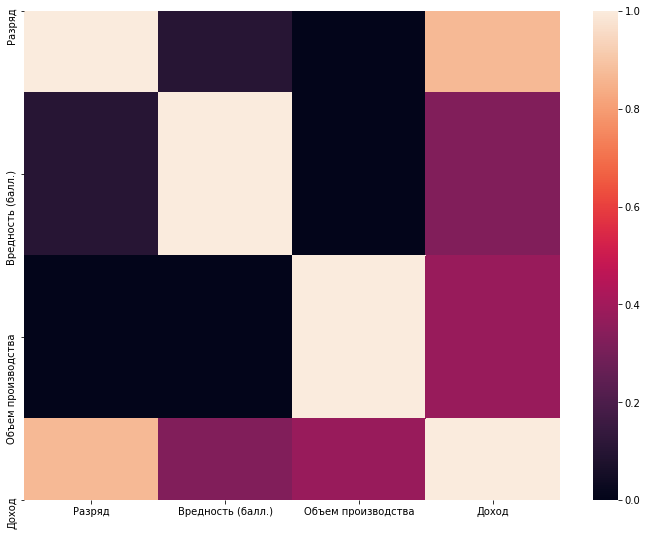

In [10]:
# Отобразим корреляции между численными признаками, включая Доход.
corrmat = data[['Разряд', 'Вредность (балл.)','Объем производства', 'Доход']].corr()
plt.subplots(figsize=(12,9))
sns.heatmap(corrmat)

Видим, что все признаки коррелируют с доходом, и при этом почти не коррелируют между собой.

Далее мы можем взглянуть на то, как категориальные признаки влияют на доход. Для этого для каждого признака, а потом для каждого значания выбранного признака возьмём среднее значение дохода. И, для наглядности, построим графики этих средних значений после сортировки.

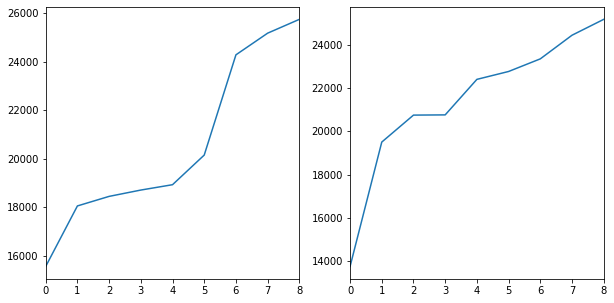

In [11]:
def cat_cor(feat):
    means = []
    for cat in list(data[feat].value_counts().index):
        means.append(data[data[feat] == cat]['Доход'].mean())
    return means

prof = cat_cor('Профессия')
oborud = cat_cor('Оборудование')

fig, axes = plt.subplots(nrows=1, ncols=2)
pd.Series(sorted(prof)).plot(ax=axes[0], figsize=(10,5))
pd.Series(sorted(oborud)).plot(ax=axes[1], figsize=(10,5))

Графики выглядят так, как будто эти признаки, если и влияют на доход, то косвенно. Так, например, можем предположить, что "разряд" не численный признак, а категориальный и посроить для него такой же график.

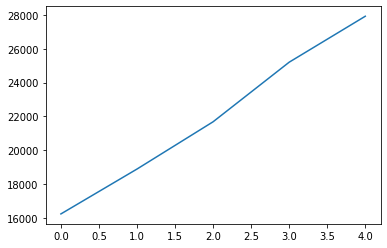

In [12]:
raz = cat_cor('Разряд')
plt.plot(sorted(raz))

Мы опять убедились, что "разряд" очень сильно влияет на доход. Остановимся пока что на мысли, что "Профессия" и "Оборудование" не влияют на "доход" непосредственно.

Теперь, перейдём к пошаговому выявлению формулы расчёта, для этого будем по возможности исключать влияние некоторых признаков и попытаемся увидеть структуру оставшихся данных.

И сразу видно, что на "доход" влияет "объём производства". Давайте взглянем на то, как он влияет на примере одного рабочего.

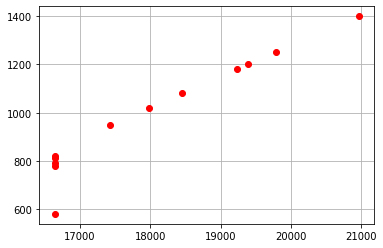

In [13]:
plt.plot(data['Доход'][:12], data['Объем производства'][:12], 'ro')
plt.grid(True)

"Объём производства" влияет на "доход" линейно, при пересечении порогового значения. До этого порога "Объём производства" не имеет значения. Поэтому можно исключить этот признак, оставив строки, в которых "объём производства" = 580.

In [14]:
data[data['Объем производства'] == 580].head(10)

,FIO,Месяц,Профессия,Разряд,Оборудование,Вредность (балл.),Объем производства,Доход
0,Абрамов Е. Д.,2009-01-01,Уборщик,3,Пилигримовые станы,18,580,16638.0
12,Абрамов Ф. М.,2009-01-01,Уборщик,3,Пилигримовые станы,18,580,16029.0
24,Агафонов С. И.,2009-01-01,Вальцовщик,6,Пилигримовые станы,18,580,22260.0
36,Аксенов Е. Н.,2009-01-01,Нагревальщик металла,7,Нагревательные печи,22,580,26020.0
48,Александров А. М.,2009-01-01,Уборщик,3,Пилигримовые станы,18,580,15420.0
60,Алексеев Н. Н.,2009-01-01,Нагревальщик металла,5,"Нагревательные печи, кантовка",22,580,20350.0
72,Андреев Е. А.,2009-01-01,Вальцовщик,5,Калибровочный стан,18,580,20449.5
84,Андреев Ф. Д.,2009-01-01,Оператор поста управления,5,Калибровочный стан,8,580,18649.5
96,Антонов В. Т.,2009-01-01,Контролер качества готовой продукции,7,Контрольно-измерительная аппаратура,0,580,22060.0
108,Баженов Д. И.,2009-01-01,Оператор поста управления,5,"Калибровочный стан, ГРП",8,580,18649.5


Следующим шагом можем исключить признак "Профессия", выбрав одну профессию и выводить таблицу рабочих только этой профессии. Взглянув на строки с рабочими с одинаковой профессии я обнаружил, что профессий "Уборщик" обладают рабочие с разным "баллом вредности". 

In [15]:
data[data['Объем производства'] == 580]\
    [data['Профессия'] == "Уборщик"]

C:\Games\ANACONDA\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


,FIO,Месяц,Профессия,Разряд,Оборудование,Вредность (балл.),Объем производства,Доход
0,Абрамов Е. Д.,2009-01-01,Уборщик,3,Пилигримовые станы,18,580,16638.0
12,Абрамов Ф. М.,2009-01-01,Уборщик,3,Пилигримовые станы,18,580,16029.0
48,Александров А. М.,2009-01-01,Уборщик,3,Пилигримовые станы,18,580,15420.0
384,Воронов Р. И.,2009-01-01,Уборщик,3,Пилигримовые станы,18,580,15420.0
468,Григорьев А. Т.,2009-01-01,Уборщик,3,Вспомогательные помещения,0,580,12180.0
612,Журавлев Б. И.,2009-01-01,Уборщик,3,Вспомогательные помещения,0,580,12180.0
792,Клюев Д. М.,2009-01-01,Уборщик,3,Вспомогательные помещения,0,580,12180.0
864,Комаров А. И.,2009-01-01,Уборщик,3,Пилигримовые станы,18,580,15420.0
912,Кондратьев Д. Д.,2009-01-01,Уборщик,3,Вспомогательные помещения,0,580,12789.0
984,Краснов И. М.,2009-01-01,Уборщик,3,Пилигримовые станы,18,580,15420.0


Можно сделать первоначальный вывод об окладе. Минимальный "доход" уборщика как раз и будет окладом - 12180.

В показанной выше таблице есть уборщики с абсолютно одинаковыми признаками, но разным доходом. И тут мы с лёгкостью можем определить, что эта разница равняется 5% и 10%. (Достаточно взглянуть на строки рабочих: Степанов А. М., Федотов М. М., Чернышев Д. В.)

In [16]:
data.loc[[2004, 2148, 2292]]

,FIO,Месяц,Профессия,Разряд,Оборудование,Вредность (балл.),Объем производства,Доход
2004,Степанов А. М.,2009-01-01,Уборщик,3,Вспомогательные помещения,0,580,12789.0
2148,Федотов М. М.,2009-01-01,Уборщик,3,Вспомогательные помещения,0,580,13398.0
2292,Чернышев Д. В.,2009-01-01,Уборщик,3,Вспомогательные помещения,0,580,12180.0


Значит доходом без индивидуальных надбавок для строк с одинаковым набором признаков будет минимальное значение дохода в подвыборке.

Таким же образом мы можем определить, что минимальный доход для уборщиков с баллом вредности, равным 18, это 15420.

In [17]:
data.loc[[0, 12, 48]]

,FIO,Месяц,Профессия,Разряд,Оборудование,Вредность (балл.),Объем производства,Доход
0,Абрамов Е. Д.,2009-01-01,Уборщик,3,Пилигримовые станы,18,580,16638.0
12,Абрамов Ф. М.,2009-01-01,Уборщик,3,Пилигримовые станы,18,580,16029.0
48,Александров А. М.,2009-01-01,Уборщик,3,Пилигримовые станы,18,580,15420.0


Таблица приведённая выше доказывает предположение о индивидуальных надбавах. Но при это ещё и подчёркивает, что балл вредности не влияет на эти надбавки, они равны 5% и 10% от 12180, то есть, оклада.

Далее, сравнив минимальный доход для уборщиков с баллом вредности, равным 18, это 15420, и минимальный доход для уборщиков с баллом вредности, равным 0, это 12180, можем предположить, что каждый балл вредности добавляет 180 к доходу. (15420 - 12180 = 3240 = 180 * 18). Формула влияния балла вредности на "доход" данным образом подтверждается и для других профессий.

Теперь взглянем на профессию "Вальцовщик". (строки с "объёмом производства" равным 580).

In [18]:
data[data['Объем производства'] == 580]\
    [data['Профессия'] == "Вальцовщик"].head()

C:\Games\ANACONDA\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


,FIO,Месяц,Профессия,Разряд,Оборудование,Вредность (балл.),Объем производства,Доход
24,Агафонов С. И.,2009-01-01,Вальцовщик,6,Пилигримовые станы,18,580,22260.0
72,Андреев Е. А.,2009-01-01,Вальцовщик,5,Калибровочный стан,18,580,20449.5
120,Белкин В. И.,2009-01-01,Вальцовщик,7,Пилигримовые станы,18,580,25300.0
168,Белоусов М. Д.,2009-01-01,Вальцовщик,6,Пилигримовые станы,18,580,23211.0
192,Богданов А. Т.,2009-01-01,Вальцовщик,7,Прошивной стан,18,580,26403.0


Видим, что "вальцовщики" имеют разряды 5, 6 и 7. Это подтверждает теорию, что признак "профессия" сам по себе не влияет на "доход", но влияет разряд.

In [19]:
data[data['Объем производства'] == 580]\
    [data['Профессия'] == "Вальцовщик"]\
    [data['Разряд'] == 5]

C:\Games\ANACONDA\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
C:\Games\ANACONDA\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


,FIO,Месяц,Профессия,Разряд,Оборудование,Вредность (балл.),Объем производства,Доход
72,Андреев Е. А.,2009-01-01,Вальцовщик,5,Калибровочный стан,18,580,20449.5
288,Винокуров М. Т.,2009-01-01,Вальцовщик,5,Калибровочный стан,18,580,20449.5
1020,Кузнецов Д. М.,2009-01-01,Вальцовщик,5,Калибровочный стан,18,580,20449.5
1032,Кузнецов О. А.,2009-01-01,Вальцовщик,5,Калибровочный стан,18,580,19630.0
1308,Михайлов С. М.,2009-01-01,Вальцовщик,5,Калибровочный стан,18,580,19630.0
1644,Поляков Д. А.,2009-01-01,Вальцовщик,5,Калибровочный стан,18,580,20449.5
1944,Соловьев В. М.,2009-01-01,Вальцовщик,5,Калибровочный стан,18,580,19630.0
2040,Терентьев М. Д.,2009-01-01,Вальцовщик,5,Калибровочный стан,18,580,19630.0
2088,Третьяков В. А.,2009-01-01,Вальцовщик,5,Калибровочный стан,18,580,20449.5
2364,Щербаков А. М.,2009-01-01,Вальцовщик,5,Калибровочный стан,18,580,19630.0


Можем сделать вывод, что индивидуальные надбавки для 5 разряда составляют 5% от минимального оклада среди вальцовщиков этого разряда (с поправкой на "балл вредности" 16390 = 19630 - 180 * 18). И это наводит на мысль, что окалды для кадого разряда разные и строго определённые.

Взглянув на полную таблицу вальцовщиков (с объёмом производства, равным 580), явно видно, что оклад для 5 разряда равен 16390, для 6 - 19020, для 7 - 22060. С помощью таблиц для рабочих с другими разрядами я определил оклады для каждого из них.
В итоге имеем оклады:

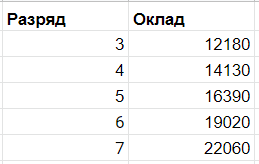

У меня есть два предположения, по поводу того, как образуется оклад: Либо оклад жёстко установлен для каждого разряда работодателем, либо он образуется по некой формуле. 

Давайте, ради интереса, попробуем получить эту формулу. "Ради интереса" - потому, что это явно не линейная функия, и мне слабо верится, что на предприятиях используют сложные формулы, приводящие к некрасивым и неудобным вычислениям и числам.

Построив график зависимости оклада от разряда, становится понятно, что функция не линейная, а скорее квадратичная. Применив полиномиальную аппроксимацию второй степени, видно, что полученная кривая очень точно ложится на график.

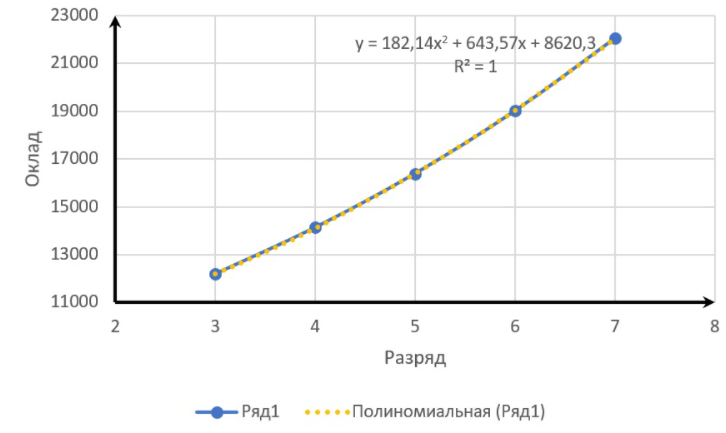

В итоге, оклад равен 182.14*x**2 + 643.57*x + 8620.3, где x - разряд

Осталось выявить влияние "Объёма производства" на "доход".

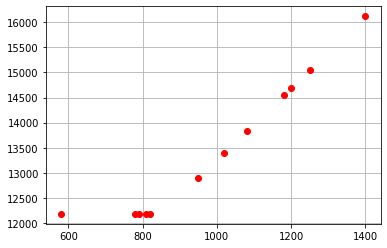

In [20]:
#График зависимости дохода от объёма производства для уборщика без надбавок и доплат
plt.plot( data['Объем производства'][468:480], data['Доход'][468:480], 'ro')
plt.grid(True)

In [21]:
# Уборщик без индивидуальных надбавок и доплат за вредность
data[468:480]

,FIO,Месяц,Профессия,Разряд,Оборудование,Вредность (балл.),Объем производства,Доход
468,Григорьев А. Т.,2009-01-01,Уборщик,3,Вспомогательные помещения,0,580,12180.000000
469,Григорьев А. Т.,2009-02-01,Уборщик,3,Вспомогательные помещения,0,790,12180.000000
470,Григорьев А. Т.,2009-03-01,Уборщик,3,Вспомогательные помещения,0,820,12180.000000
471,Григорьев А. Т.,2009-04-01,Уборщик,3,Вспомогательные помещения,0,1200,14687.647059
472,Григорьев А. Т.,2009-05-01,Уборщик,3,Вспомогательные помещения,0,1250,15045.882353
473,Григорьев А. Т.,2009-06-01,Уборщик,3,Вспомогательные помещения,0,950,12896.470588
474,Григорьев А. Т.,2009-07-01,Уборщик,3,Вспомогательные помещения,0,1400,16120.588235
475,Григорьев А. Т.,2009-08-01,Уборщик,3,Вспомогательные помещения,0,1180,14544.352941
476,Григорьев А. Т.,2009-09-01,Уборщик,3,Вспомогательные помещения,0,1080,13827.882353
477,Григорьев А. Т.,2009-10-01,Уборщик,3,Вспомогательные помещения,0,780,12180.000000


In [22]:
# Уборщик без индивидуальнымх надбавок и с доплатой за вредность
data[48:60]

,FIO,Месяц,Профессия,Разряд,Оборудование,Вредность (балл.),Объем производства,Доход
48,Александров А. М.,2009-01-01,Уборщик,3,Пилигримовые станы,18,580,15420.000000
49,Александров А. М.,2009-02-01,Уборщик,3,Пилигримовые станы,18,790,15420.000000
50,Александров А. М.,2009-03-01,Уборщик,3,Пилигримовые станы,18,820,15420.000000
51,Александров А. М.,2009-04-01,Уборщик,3,Пилигримовые станы,18,1200,17927.647059
52,Александров А. М.,2009-05-01,Уборщик,3,Пилигримовые станы,18,1250,18285.882353
53,Александров А. М.,2009-06-01,Уборщик,3,Пилигримовые станы,18,950,16136.470588
54,Александров А. М.,2009-07-01,Уборщик,3,Пилигримовые станы,18,1400,19360.588235
55,Александров А. М.,2009-08-01,Уборщик,3,Пилигримовые станы,18,1180,17784.352941
56,Александров А. М.,2009-09-01,Уборщик,3,Пилигримовые станы,18,1080,17067.882353
57,Александров А. М.,2009-10-01,Уборщик,3,Пилигримовые станы,18,780,15420.000000


По аналогии, будем искать зависимость прироста дохода с ростом объёма производства от других признаков.

Начнём с вредности. Сравним разницу между доходом при объёме производства 1400 и 580 для уборщика с доплатой за вредность и уборщика без доплаты:

In [23]:
print("Премия уборщика с баллом вредности:", 19360.588235 - 15420)
print("Премия уборщика без балла вредности:", 16120.588235 - 12180)

Премия уборщика с баллом вредности: 3940.5882349999993
Премия уборщика без балла вредности: 3940.5882349999993


Премия не зависит от балла вредности.

Далее посмотрим на влияние индивидульной надбавки:

In [24]:
# Уборщик с инд. доплатой в 10%
data[:12]

,FIO,Месяц,Профессия,Разряд,Оборудование,Вредность (балл.),Объем производства,Доход
0,Абрамов Е. Д.,2009-01-01,Уборщик,3,Пилигримовые станы,18,580,16638.000000
1,Абрамов Е. Д.,2009-02-01,Уборщик,3,Пилигримовые станы,18,790,16638.000000
2,Абрамов Е. Д.,2009-03-01,Уборщик,3,Пилигримовые станы,18,820,16638.000000
3,Абрамов Е. Д.,2009-04-01,Уборщик,3,Пилигримовые станы,18,1200,19396.411765
4,Абрамов Е. Д.,2009-05-01,Уборщик,3,Пилигримовые станы,18,1250,19790.470588
5,Абрамов Е. Д.,2009-06-01,Уборщик,3,Пилигримовые станы,18,950,17426.117647
6,Абрамов Е. Д.,2009-07-01,Уборщик,3,Пилигримовые станы,18,1400,20972.647059
7,Абрамов Е. Д.,2009-08-01,Уборщик,3,Пилигримовые станы,18,1180,19238.788235
8,Абрамов Е. Д.,2009-09-01,Уборщик,3,Пилигримовые станы,18,1080,18450.670588
9,Абрамов Е. Д.,2009-10-01,Уборщик,3,Пилигримовые станы,18,780,16638.000000


In [25]:
print("Премия уборщика с индивидуальной надбавкой в 10%:", 20972.647059 - 16638)

Премия уборщика с индивидуальной надбавкой в 10%: 4334.647058999999


Приемия получилась больше. Скорее всего, индивидуальная надбавка накладывается также на премию, проверим это:

In [26]:
print("Премия уборщика без надбавки с домножением на коэффициент надбавки:",3940.5882349999993 * 1.1)

Премия уборщика без надбавки с домножением на коэффициент надбавки: 4334.6470585


In [27]:
def prime_count(data, fio):
    data_fio = data[data['FIO'] == fio]
    string = data_fio[data_fio['Объем производства'] == 580]
    
    raz = int(string['Разряд'])
    vred = int(string['Вредность (балл.)'])

    oklad = pd.DataFrame({'Разряд': [3, 4, 5, 6, 7],
                          'Оклад': [12180, 14130, 16390, 19020, 22060]})
    
    indiv_nadbavka = round((float(string['Доход']) - vred * 180 - float(oklad[oklad['Разряд'] == raz]['Оклад']))\
                     / float(oklad[oklad['Разряд'] == raz]['Оклад']), ndigits = 2)# 0,0.05,0.1

    prime = ((float(data_fio[data_fio['Объем производства'] == 1400]['Доход']) - vred*180) - \
            (float(data_fio[data_fio['Объем производства'] == 950]['Доход']) - vred*180)) / \
            ((indiv_nadbavka + 1) * 450) # 
    
    return prime

In [28]:
fio = data[data['Разряд'] == 7][data['Объем производства'] == 580]['FIO'].iloc[3]
print(fio)
prime = prime_count(data, fio)
print('Премия без инд. надбавки за единицу пеработки объёма производства:', prime)

Белкин Г. В.
Премия без инд. надбавки за единицу пеработки объёма производства: 12.976470588235445


C:\Games\ANACONDA\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


C помощью этой функции выясняется, что для разных разрядов премия за единицу объёма производства сверх нормы равна разным значениям. Также, эта функция учитывает индивидуальную надбавку и доплату за вредносоь, таким образом, на выходе всегда получается одинаковое число для каждого разряда.



Теперь посмотрим, как от разряда зависит отношение премии за еденицу переработки и оклада для выбранного разряда.

In [29]:
raz = 7
oklad = pd.DataFrame({'Разряд': [3, 4, 5, 6, 7],
                          'Оклад': [12180, 14130, 16390, 19020, 22060]})

fio = data[data['Разряд'] == raz][data['Объем производства'] == 580]['FIO'].iloc[0]
print(fio)
prime = prime_count(data, fio)
print(prime)
print(float(oklad[oklad['Разряд'] == raz]['Оклад']))
print('Премия за единицу переработки, делённая на оклад для этого разряда:', prime/float(oklad[oklad['Разряд'] == raz]['Оклад']))

Аксенов Е. Н.
12.976470588235445
22060.0
Премия за единицу переработки, делённая на оклад для этого разряда: 0.000588235294117654


C:\Games\ANACONDA\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """


Расчитываемое отношение получается одинаковым для любого разряда и равно 0.000588.

Значит премия = оклад * инд.надбавка * разница объёмов * К, где К = 0.000588, разница объёмов = объём производства - 850

Напишем функцию расчёта дохода, чтобы убедиться в правильности полученной формулы:

In [30]:
def dohod(data, string):
    
    raz = int(string['Разряд'])
    
    vred = int(string['Вредность (балл.)'])
    
    ob_proizv = int(string['Объем производства'])
    
    oklad_table = pd.DataFrame({'Разряд': [3, 4, 5, 6, 7],
                          'Оклад': [12180, 14130, 16390, 19020, 22060]})
    
    oklad = float(oklad_table[oklad_table['Разряд'] == raz]['Оклад'])
    
    indiv_nadbavka = round(
                            (float(data[data['FIO'] == string['FIO']]\
                                       [data['Объем производства'] == 580]['Доход'])\
                            - vred * 180 - oklad) / oklad, 
                            ndigits = 2
                            )    # 0,0.05,0.1
    
    k = 0.0005882
    border = 850
    
    prime = oklad * (indiv_nadbavka + 1) * max(0, (ob_proizv - border)) * k

    result = oklad + prime + vred*180 + oklad * indiv_nadbavka
    return (string['Доход'], result)

Чтобы провести сравнение реального и расчётного дохода создадим DataFrame, в котором будут столбцы: Реальный доход, Расчётный доход и Правильность (0 или 1), а количество строк равно количеству строк исходных данных.

In [34]:
compare = pd.DataFrame({'Реальный доход': np.zeros(len(data)),
                        'Расчётный доход': np.zeros(len(data)),
                        'Правильность': np.zeros(len(data))
                       })
                       
for id_string in range(len(data)):
    d = dohod(data, data.iloc[id_string])
    compare.iloc[id_string]['Реальный доход'] = d[0]
    compare.iloc[id_string]['Расчётный доход'] = d[1]
    compare.iloc[id_string]['Правильность'] = int(math.isclose(d[0], d[1], rel_tol=0.1))

C:\Games\ANACONDA\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


In [35]:
compare

,Реальный доход,Расчётный доход,Правильность
0,16638.000000,16638.000000,1.0
1,16638.000000,16638.000000,1.0
2,16638.000000,16638.000000,1.0
3,19396.411765,19396.246260,1.0
4,19790.470588,19790.281440,1.0
...,...,...,...
2395,21800.170588,21799.989558,1.0
2396,20885.876471,20885.750298,1.0
2397,18783.000000,18783.000000,1.0
2398,20337.300000,20337.206742,1.0


In [33]:
compare['Правильность'].sum()

2400.0

Ответ:

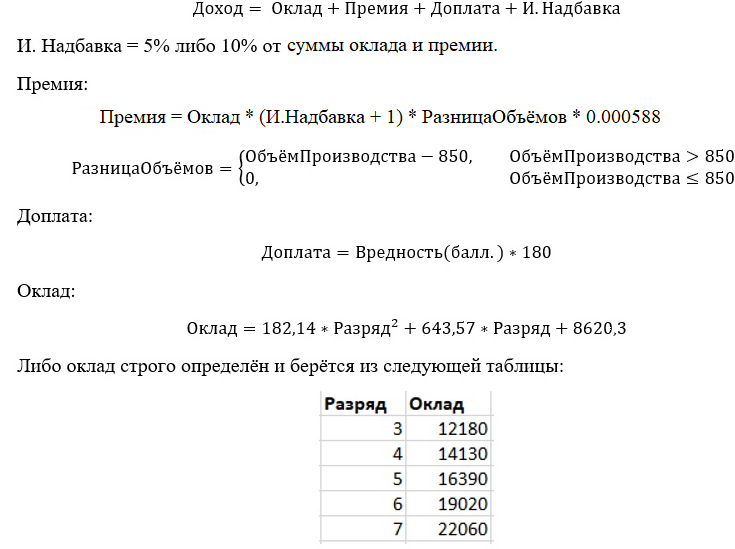